The purpose of this notebook is to **check different scalers** on the data, and **determine** which may be **best** for scaling the data as a **pre-processing step to the K-Means**. 

In [1]:
import matplotlib
matplotlib.use('nbagg')

import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import pandas as pd
import time
import seaborn as sb
import pprint 

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

The following line is for preventing warnings raised for operations done on copied slices of data frames. See here mid-page for more info.
In short, as the default state for the copy action is 'deep = True', the data-frame that is created is indeed a copy and not a view, and so actions on it won't change the original frame it is copied from.

In [3]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = [by_column])
        print("The data-frame was sorted by the {} column.\n".format(by_column))
    
    return data

In [6]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = 0.5 * np.diff(bins) + bins[:-1]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel("Count", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [7]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [17]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [19]:
def run_revenue_init_data_analysis(data_target_revenue,
                                   target_column,
                                   plot_figures = True, 
                                   print_to_screen = True):
    
    # Calculating the total revenue of a given user (as a user might have had several purchase events in a day)
    data_target_revenue[target_column] = data_target_revenue.groupby(['dim_user_gid'])['revenue_converted_net'].transform('sum').astype(float)

    # Adding a column with the number of purchase events of a user
    data_target_revenue['num_purchase_events_of_user'] = data_target_revenue.groupby('dim_user_gid')['dim_user_gid'].transform('size')

    # Keeping just the information per a user id
    data_target_revenue = data_target_revenue.drop_duplicates(subset=['dim_user_gid']).drop('revenue_converted_net', axis = 1)
    
    if plot_figures: 
        print("\n\nLooking at the distribution of the revenue at the given day:")
        n_bins = 200
        plot_loglog_scale(data_target_revenue, target_column, n_bins)
        
#         print("\n\nLooking at the revenue as a function of the user's index in the data frame:")
#         print("(which is a proxy to the user's ID, which is a proxy to the user's seniority)")
#         marker_size = 2
#         plot_data_by_index(data_target_revenue, target_column, marker_size)
        

    if print_to_screen:
        print("\nThe shape of the target data frame is:\n{}".format(data_target_revenue.shape))
        print("\nThere are {} **zeros** and {} **nan** in the {} column".format(len(data_target_revenue[data_target_revenue[target_column] == 0]), \
                                                                                data_target_revenue[target_column].isnull().sum(), \
                                                                                target_column))
        print("\nAnd the types of the data is:")
        print(data_target_revenue.dtypes)
    
    
    return data_target_revenue

In [11]:
target_full_file_name = "Data/data_target_revenue_20220916.pkl"

In [12]:
data_target = read_data_from_pickle(target_full_file_name)
data_target.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 103211 different rows, and 2 different columns.
There are 51856 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,revenue_converted_net
17184,600,2.9153
81484,1240,3.4930
85786,1307,0.6230
34537,1621,10.4930
72900,1788,6.2930
72899,1788,6.2930
72898,1788,6.2930
72897,1788,0.6930
72896,1788,10.4930
21602,2082,19.5930


In [13]:
target_column = "Total_revenue_at_day"



Looking at the distribution of the revenue at the given day:


<ipython-input-17-207e611714e3>:4: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


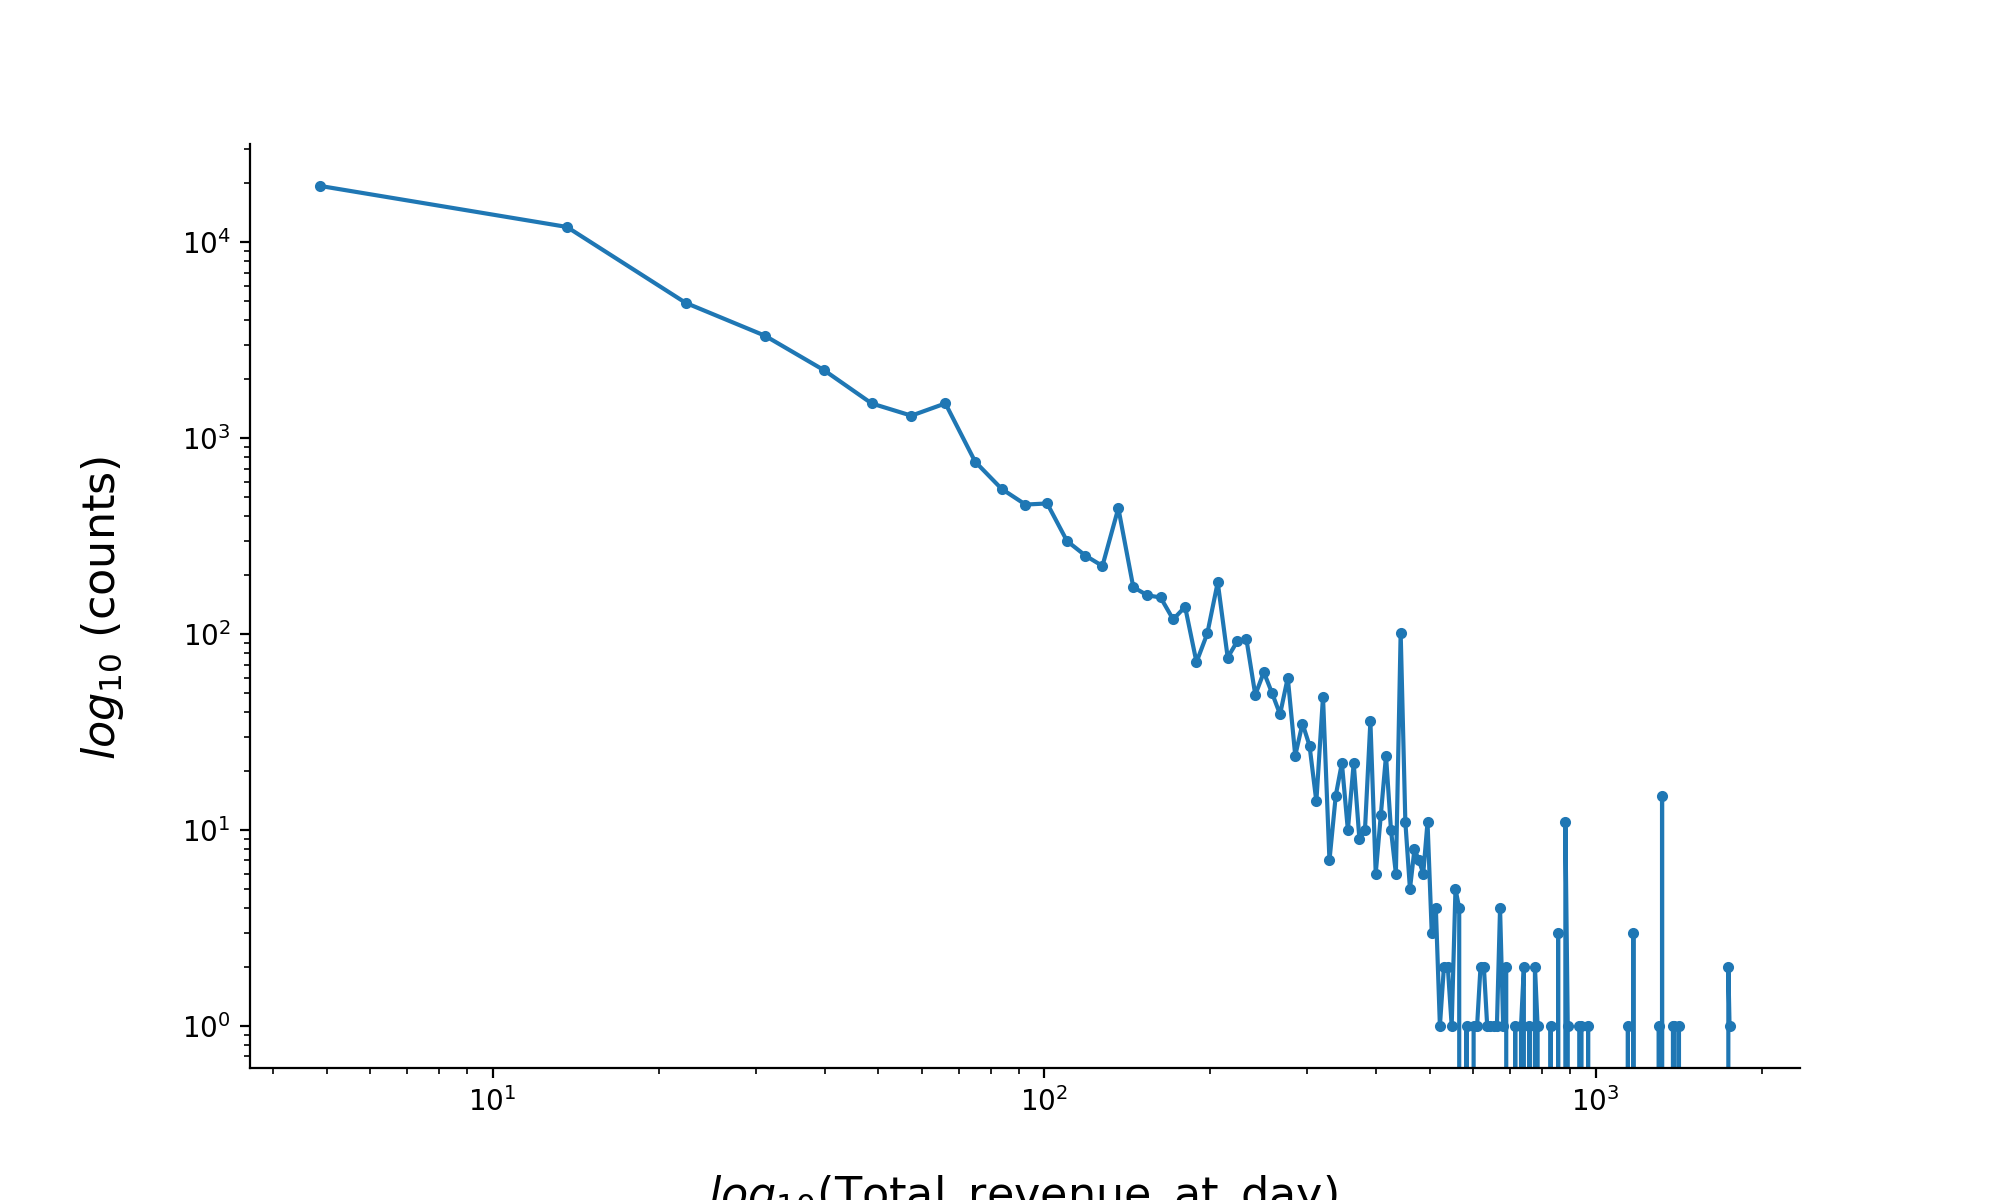


The shape of the target data frame is:
(51856, 3)

There are 0 **zeros** and 0 **nan** in the Total_revenue_at_day column

And the types of the data is:
dim_user_gid                     int64
Total_revenue_at_day           float64
num_purchase_events_of_user      int64
dtype: object


In [20]:
data_target = run_revenue_init_data_analysis(data_target, 
                                             target_column)

<IPython.core.display.Javascript object>


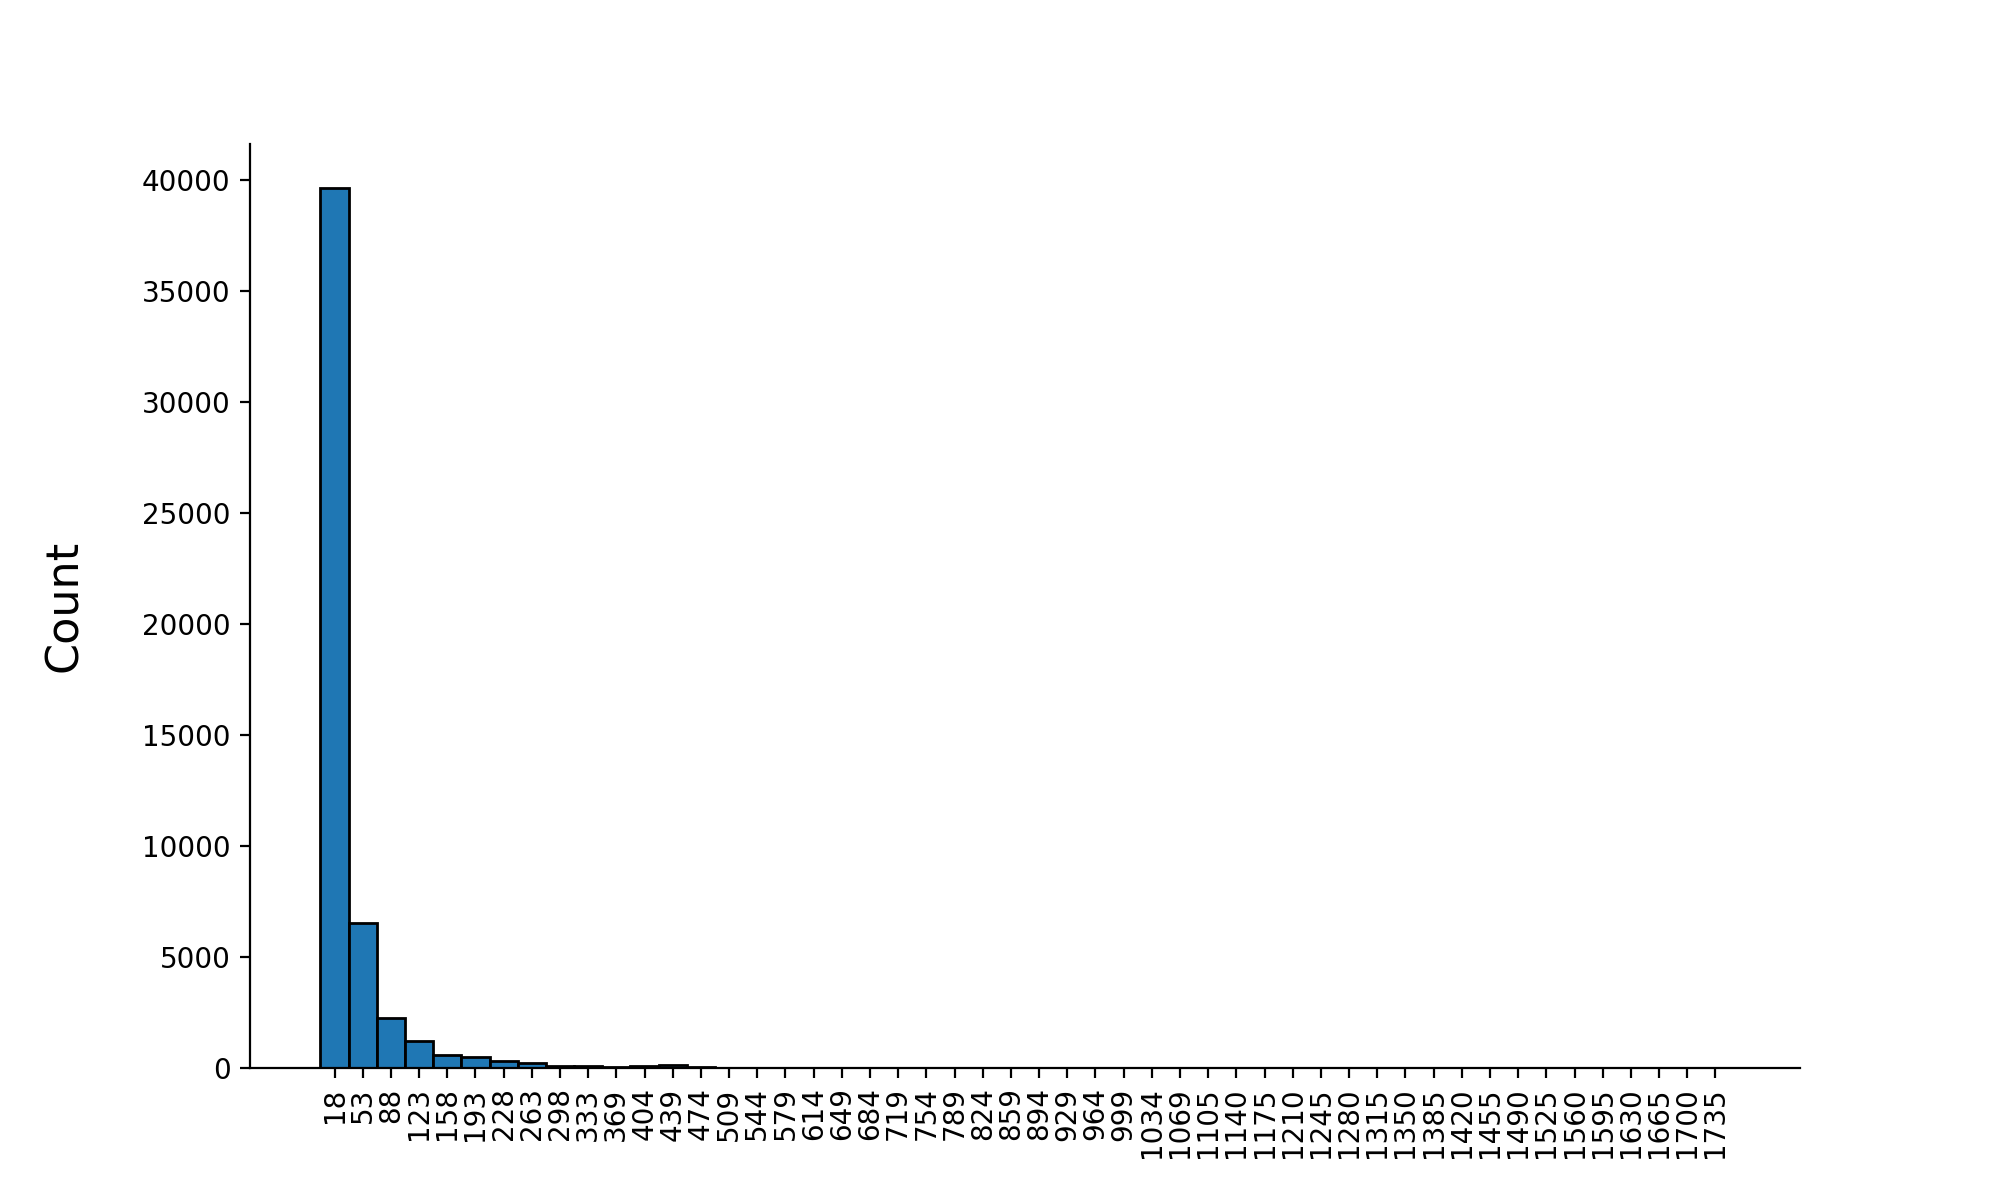

In [21]:
n_bins = 50
hist_of_numerical_feature(data_target, target_column, n_bins)

In [24]:
data_target_Standard_Scaler = StandardScaler().fit_transform(data_target[target_column])

ValueError: Expected 2D array, got 1D array instead:
array=[2.9153 3.493  0.623  ... 0.693  0.6642 0.7184].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [23]:
n_bins = 50
hist_of_numerical_feature(data_target_Standard_Scaler, target_column, n_bins)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices